**Deep Learning Assignment by Rishi Gupta (20231111)**

Import Python libraries

In [1]:
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.applications import InceptionResNetV2
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing import image
from matplotlib import pyplot as plt
import glob
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
from keras.preprocessing.image import img_to_array,load_img
import cv2
%matplotlib inline
import pandas as pd
import warnings

In [2]:
warnings.filterwarnings("ignore")

**Part 1**

**Chest Xray Dataset Link**

In [ ]:
https://drive.google.com/file/d/1VjV5lAMV6MRvNYd-QURYQKnyNmC7ou5H/view?usp=sharing

In [3]:
#Extract the Chest xray dataset including train, validation, test and some new sample images folder
!unzip /content/drive/MyDrive/DL_Assignment2/chest_xray_dataset.zip

**Dataset: Chest Xray for detecting Pneumonia**

**Background** - 
Chest X-Rays in Patients with Pneumonia. The normal chest X-ray shows clear lungs without any viral or bacterial infection in the image. Pneumonia xray typically exhibits an infection with  a focal lobar consolidation for bacterial infection or contains a more diffuse ‘‘interstitial’’ pattern in both lungs for viral infection.

**Shape/Size** -
The shape of the image is resized to (150,150,3). Earlier the images were of different shapes and size with 3 as RGB channel fixed.

**Classes** -
There are 2 classes in the dataset.

1.   Class 0 - This class includes images which are normal and shows no pneumonia infection in lungs xray.
2.   Class 1 - This class includes images which shows pneumonia infection in lungs xray.

**Method of Collection** -
The dataset was taken from Kaggle competition and modified a little bit to increase the images fom google for both classes.

**Normal (Class 0) Image**
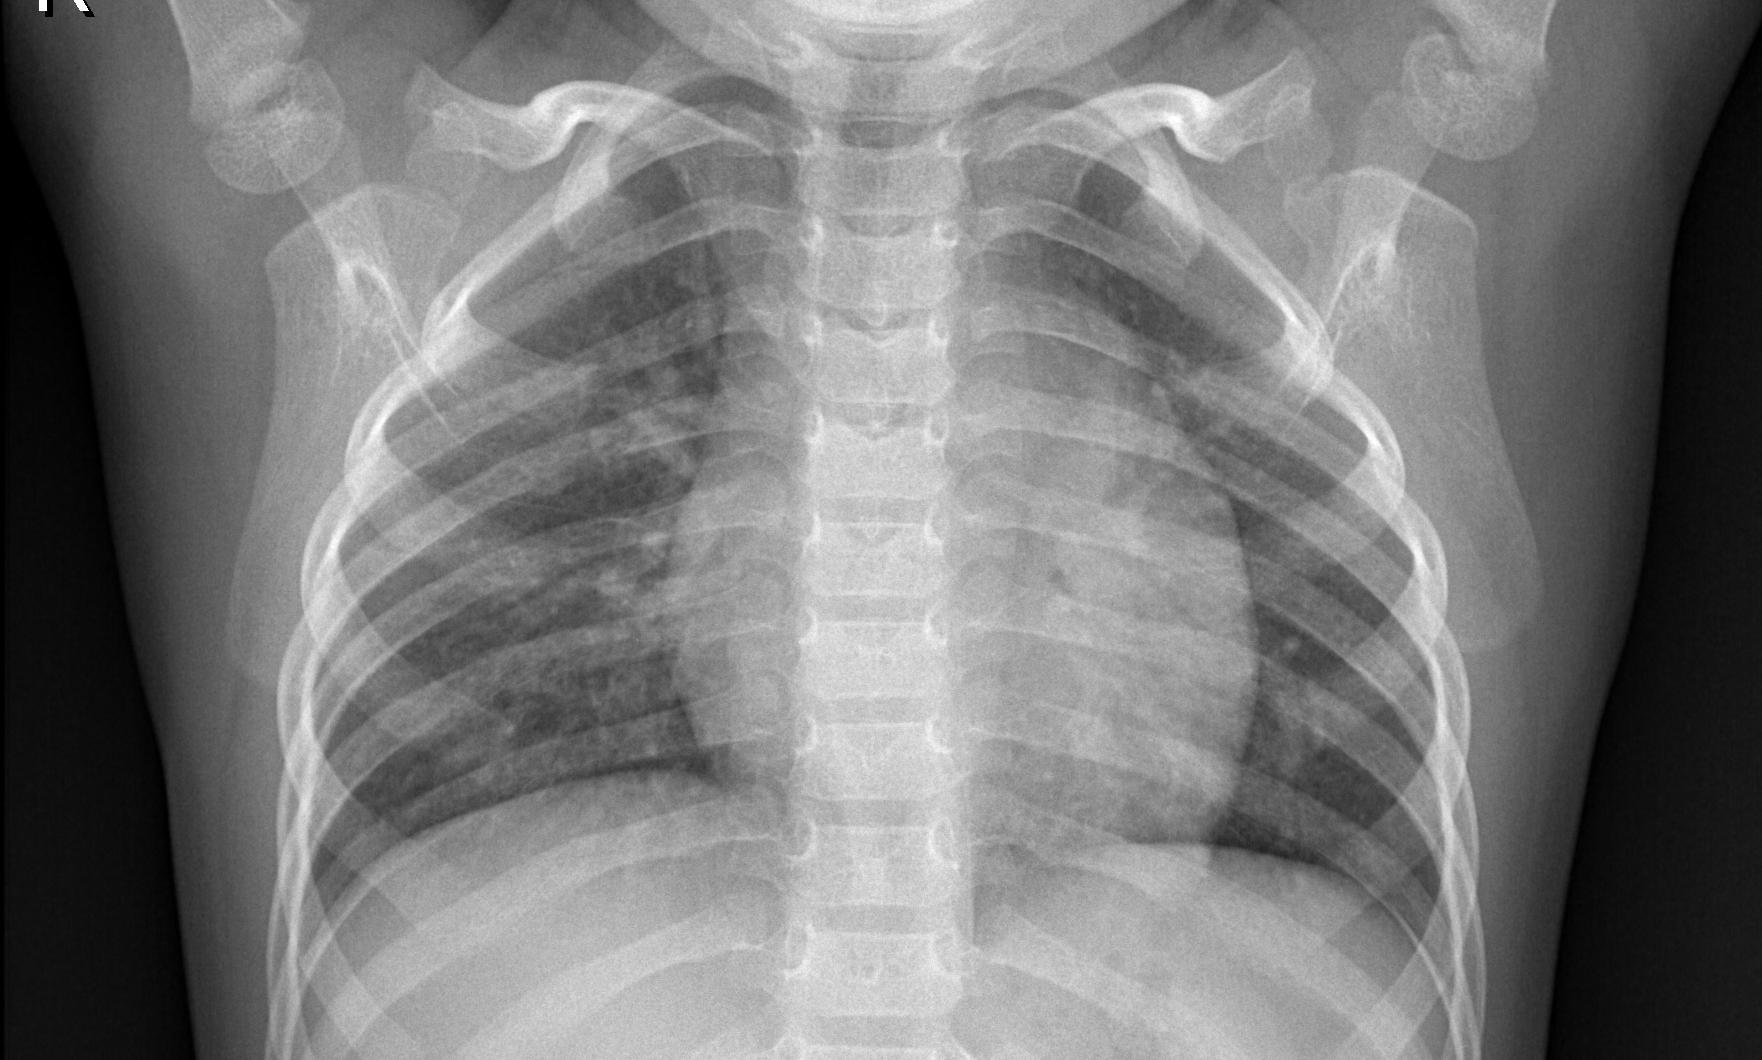

**Pneumonia (Class 1) Image**
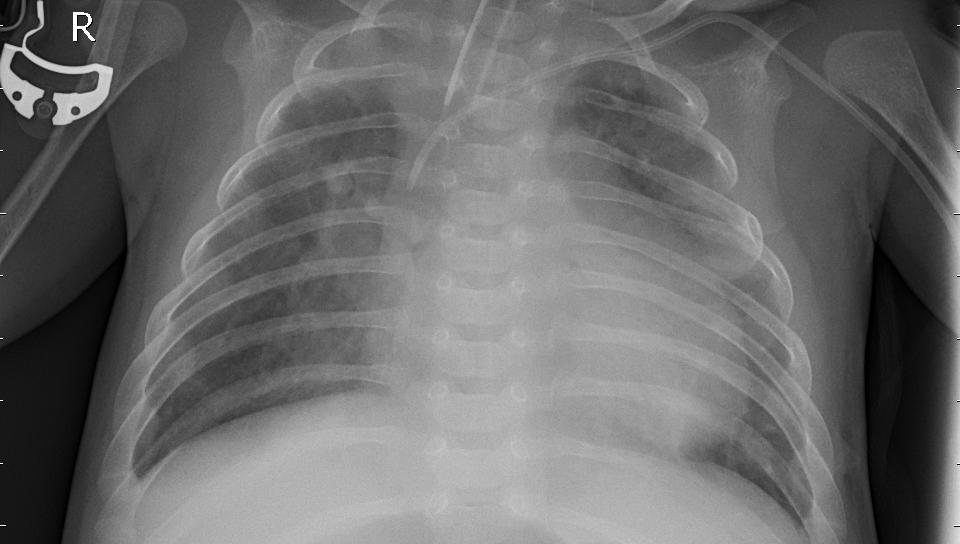

**Part 2**

Report your choice of base model; state and
explain the shape of the base model’s output; explain the layers you added and training carried out;
report classification performance on unseen data.

**Pre-Trained Model Selected**
The pre-trained model selected is InceptionResNetV2

**Shape of Base Model's Output**
The shape of the base model's output layer which is conv_7b_ac (Activation)     is (None, 3, 3, 1536) where 1536 are number of neurons in the layer and 3 is RGB channel.

**Layers added to base model**
The layers added to base model are as following:


1.   Flatten Layer to pass it to our fully connected layer (classifier).
2.   Dense Layer with an output of 256 and ReLU as activation.
3.   Last layer is Dense with an output of 1 and sigmoid as activation because  we want to predict probability of the classes and get a single probability of predicted class.

**Training carried out**
After adding the final layers to base model for prediction we first put base layer's layer.trainable as False as it reduces our trainable parameters and we no further need to train the pre-trained model completely.

Then after the above step we compile the new classification with loss parameter as 'binary_crossentropy', optimizer as RMSprop with learning rate of 2e-5 and metrics as 'accuracy'.

After compiling the model, we train our model but before that we have done some data pre-processing like creating training and validation into batches of 30 data using Imagedatagenerator and also performed normalization. 

We train our model by using fit_generator and train the model on training data with validation data for validation. Some parameters for training are:

1.   Number of epochs - 5
2.   Steps_per_epoch - Number of training images / batch_size =  3000/30 = 100
3.   validation_steps - Number of validation images / batch_size =  300/30 = 10

The model is trained for 5 epochs with steps of 100. 

Finally!!! the model is trained with an training accuracy of 95.31% and a validation accuracy of 93.67%.

**Classification Performance**
The model is evaluated on a testing data with an accuracy of 92.57%.


In [4]:
#creating path for training, validation and test images
train_dir = 'chest_xray_dataset/train/' 
validation_dir = 'chest_xray_dataset/val/'
test_dir = 'chest_xray_dataset/test/' 

In [5]:
#creating image data using ImageDataGenerator for train, validation and test and normalizing the images.
train_datagen = ImageDataGenerator(rescale=1./255)  
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
#Using data generator object reading the images for train and valid from the directory and resizing the image to 150,150 with color mode as rgb (3 channel) and as 
#there are two classes in the dataset so using class mode as binary for image classification 
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=30,
    class_mode="binary",
    shuffle=True,
    seed=42
)
valid_generator = val_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=30,
    class_mode="binary",
    shuffle=True,
    seed=42
)

Found 3000 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


Pneumonia


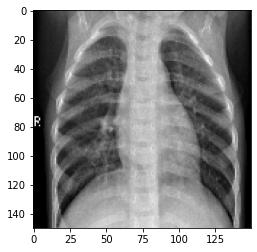

Normal


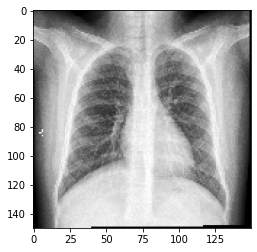

Pneumonia


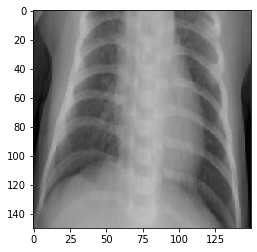

Normal


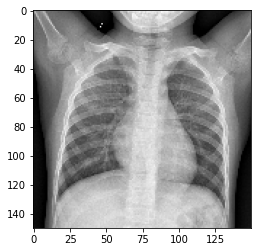

Pneumonia


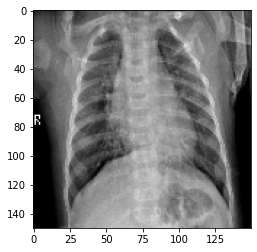

Normal


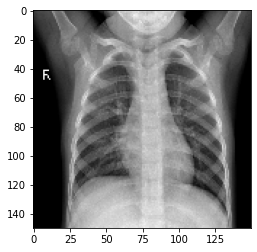

Normal


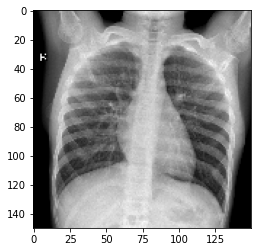

Pneumonia


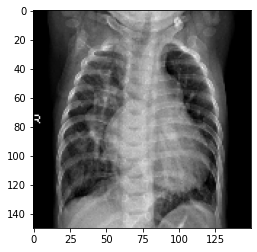

Normal


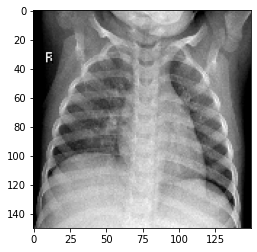

Pneumonia


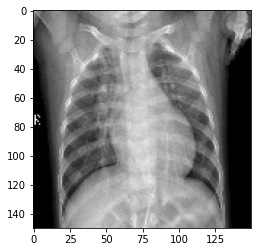

In [7]:
#Plotting some train images for both Normal and Pneumonia xray images
x_batch, y_batch = next(train_generator)
for i in range (0,10):
  if y_batch[i] == 0.0:
    print("Normal")
  else:
    print("Pneumonia")
  image = x_batch[i]
  plt.imshow(image)
  plt.show()

In [8]:
#Checking the image size and batch size in train
for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

data batch shape: (30, 150, 150, 3)
labels batch shape: (30,)


In [9]:
Image_shape = (150, 150,3)  ## image size for input to InceptionResNetV2

**Load the Pre-trained Model**

In [10]:
# Load InceptionResNetV2 as our base model with weights from imagenet and excluding the top classification layer as we dont want to classify on our new data
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape = Image_shape) 

In [11]:
base_model.summary() # Check model layer details using summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________

In [12]:
#Freeze the original layers of InceptionResNetV2
for layer in base_model.layers:
    layer.trainable = False

In [13]:
#Adding layers to the base model for classification
x = base_model.output #Taking base model's output as inout to our classification model
x = layers.Flatten()(x) #Flatten the output from the base model to pass it to our fully connected classifier layer
x = layers.Dense(256, activation='relu')(x) #Dense layer with relu activation
predictions = layers.Dense(1, activation='sigmoid')(x) #Dense layer with output 1 for a probability of a class with activation as sigmoid
# this is the model we will train
class_model = keras.Model(inputs=base_model.input, outputs=predictions)

In [14]:
class_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
# Model compile with learning rate of 2e-5 and loss as binary_crossentropy as its a binary classification
class_model.compile(loss="binary_crossentropy",optimizer=optimizers.RMSprop(lr=2e-5),metrics=["accuracy"])

In [16]:
# Training our classification model using fit on training data with epoch as 5
history = class_model.fit_generator(train_generator, steps_per_epoch = 100,validation_data=valid_generator,validation_steps=10, epochs=5)

Epoch 1/5
100/100 [==============================] - 347s 3s/step - loss: 0.4831 - accuracy: 0.8158 - val_loss: 0.2130 - val_accuracy: 0.9100
Epoch 2/5
100/100 [==============================] - 340s 3s/step - loss: 0.2135 - accuracy: 0.9161 - val_loss: 0.1545 - val_accuracy: 0.9333
Epoch 3/5
100/100 [==============================] - 334s 3s/step - loss: 0.1855 - accuracy: 0.9295 - val_loss: 0.1511 - val_accuracy: 0.9433
Epoch 4/5
100/100 [==============================] - 345s 3s/step - loss: 0.1366 - accuracy: 0.9474 - val_loss: 0.1464 - val_accuracy: 0.9433
Epoch 5/5
100/100 [==============================] - 329s 3s/step - loss: 0.1177 - accuracy: 0.9531 - val_loss: 0.1425 - val_accuracy: 0.9367


**Plot the accuracy and loss on Training and Validation**

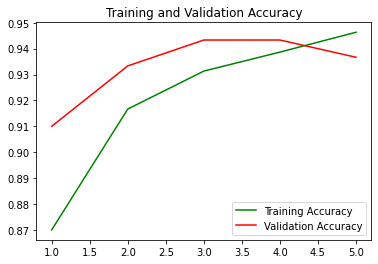

In [17]:
#Getting accuracy and loss data from the history of model trained on 5 epochs
accuracyy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(accuracyy)+1)

#Plotting accuracy per epoch for training and validation
plt.plot(epochs, accuracyy, 'g', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

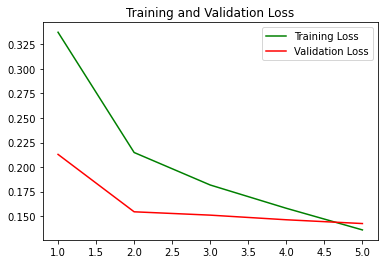

In [18]:
#Plotting loss per epoch for training and validation
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

**Saving Classification Model**

In [19]:
class_model.save('Normal_vs_Pneumonia_Detection_Model.h5') #Its good to save model after training.

**Model Evaluation on Test data**

In [20]:
# Read test data using data generator from test directory and resize it to 150,150 for evaluating the model
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150, 150),
batch_size=20,
class_mode='binary')
test_loss, test_acc = class_model.evaluate_generator(test_generator, steps=35) #Evaluate class model on test data
print('Accuracy on Test data is:', test_acc)
print('Loss on Test data is:', test_loss)

Found 700 images belonging to 2 classes.
Accuracy on Test data is: 0.9257143139839172
Loss on Test data is: 0.1907833218574524


**Model Prediction on New images**

In [21]:
#Function to predict the class of a new xray image
def pred(img_path):    
  img = []
  im= cv2.imread(filename)
  img.append(cv2.resize(im,(150,150))) #Resize new image to model inout size
  X_sample = np.array(img)
  x_sample = X_sample / 255 #Image normalization
  return (class_model.predict(x_sample)) #Use model.predict to predict the probability of class
  

In [22]:
for filename in glob.glob('chest_xray_dataset/new_samples/*.jpeg'): 
  y_pred = pred(filename) 
  if y_pred > 0.5: #If probability is greater than threshold i.e 0.5 then class is pneumonia else xray is normal
    print("For image {} Pneumonia detected".format(filename.split('samples/')[1].split('.')[0]))
  else:
    print("For image {} Pneumonia not detected".format(filename.split('samples/')[1].split('.')[0]))
  z = plt.imread(filename) 
  plt.imshow(z) #Plot new images with ther predicted class
  plt.show()
  

Output hidden; open in https://colab.research.google.com to view.

**Part 3**

**Method**
Getting the neurons output probabilites from softmax layer by predicting on test data and then finding the correlation between all neurons and class label by taking all data in pandas dataframe.

After getting the correlation data extracting the correlation values of class label with all 1536 neurons and storing the values in list.

Getting the top 5 positive and top 5 negative correlation values and getting top 10 highly correlated neurons with class label.

**Highly Correlated Neurons**
The neurons highly correlated with the class label are: 844, 1450, 1297, 1316, 437, 1084, 1511, 1529, 357, 574

**Interpretation**
The highly correlated neurons are considered as weak class detectors as they are biased towards a class label and hence, may lead to misclassification of class label due to these neuron types.

In [23]:
#Adding new layers for getting neuron correlation with class
l = base_model.output
l = layers.GlobalAveragePooling2D()(l) # add a global spatial average pooling layer
predictions = layers.Softmax()(l) # Softmax layer getting probabilities for all neurons in output layer
updated_model = keras.Model(inputs=base_model.input, outputs=predictions)

In [24]:
updated_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [25]:
normal_images_test_list = []  ## reading images of normal xrays from path and storing in this list
pneumonia_images_test_list = []  ## reading images of pneumonia xrays from path and storing in this list

#Reading data from test for both classes for prediction
for filename in glob.glob('chest_xray_dataset/test/NORMAL/*.jpeg'): 
    im= cv2.imread(filename)
    normal_images_test_list.append(cv2.resize(im,(150,150)))
for filename in glob.glob('chest_xray_dataset/test/PNEUMONIA/*.jpeg'): 
    im= cv2.imread(filename)
    pneumonia_images_test_list.append(cv2.resize(im,(150,150)))
#Take 25 images from both class for prediction
X_pred = np.array(normal_images_test_list[:25])
X_pred = np.concatenate((X_pred,np.array(pneumonia_images_test_list[:25])))
y_pred = np.zeros(len(normal_images_test_list[:25]))
y_pred = np.concatenate((y_pred, np.ones(len(pneumonia_images_test_list[:25]))))
## normalizing the images
X_pred_scaled = X_pred / 255

In [26]:
#Predict the probabilities using the updated model on testing data
yhat = updated_model.predict(X_pred_scaled)
print(yhat.shape)

(50, 1536)


**Finding Highly Correlated Neurons with class labels**

In [27]:
#Store the predicted probabilites for 1536 neurons as columns and 50 images as rows in Pandas dataframe 
neurons_data = pd.DataFrame(yhat)
neurons_data['Class_Label'] = y_pred # Add the class label as target column in the dataframe 
correlated_data = neurons_data.corr() # Find correlation of each column with all other columns
class_label_correlation = correlated_data.iloc[:,-1] #Extract the target column correlation values with all 1536 neurons
class_label_correlation = list(class_label_correlation)[:-1] #Convert the pandas series to list and remove the last value as its correlation of class label with itself which is 1
top_5_positive_correlated_idx = sorted(range(len(class_label_correlation)), key=lambda i: class_label_correlation[i], reverse=True)[:5] #Find the top 5 positive correlated neuron with class label
top_5_negative_correlated_idx = sorted(range(len(class_label_correlation)), key=lambda i: class_label_correlation[i], reverse=False)[:5] #Find the top 5 positive correlated neuron with class label
highly_correlated_neurons_list = top_5_positive_correlated_idx + top_5_negative_correlated_idx # List of top 10 highly correlated neurons
neurons_idx = (", ").join([str(x) for x in highly_correlated_neurons_list])
print("Top Correlated Neurons indexes are:",neurons_idx)

Top Correlated Neurons indexes are: 844, 1450, 1297, 1316, 437, 1084, 1511, 1529, 357, 574


**Part 4**

**Interpretation**
As we can see from the 2D ouput of highly correlated neurons we can see some colored boxes can be seen in the image on new data so they are clearly allowing localization of object in the input image.

When we plot 2D ouput of very low correlated neurons we see no colored boxes in the imagee and rather a single colored image which shows they are not able to perform object localization in the input image.

Concluding from the above interpretation, neurons which are not very highly or very low correlated with class labels are the better class detectors.

In [28]:
pred_list = []
image_name_list = []
#Read new images for object localization using the highly correlated nueron
for filename in glob.glob('chest_xray_dataset/new_samples/*.jpeg'):
  image_name_list.append(filename.split('new_samples/')[1].split('.')[0])
  im= cv2.imread(filename)
  pred_list.append(cv2.resize(im,(150,150)))
X = np.array(pred_list)
x_pred = X / 255

**Highly Correlated 2D Output For Object Localization**

Object Localization for image test16:


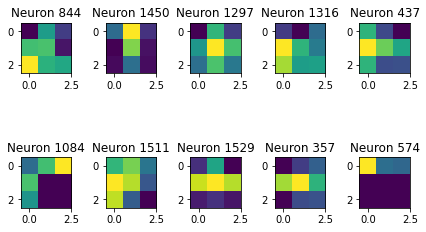



Object Localization for image test5:


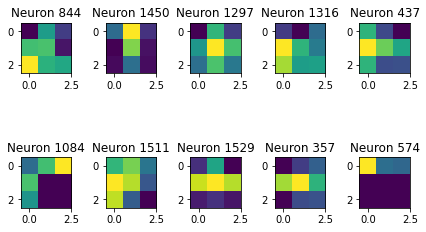



Object Localization for image test19:


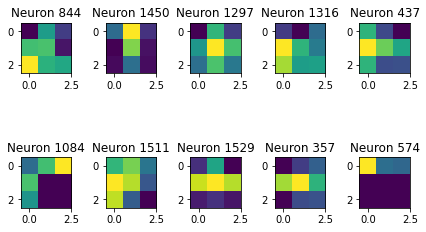



Object Localization for image test4:


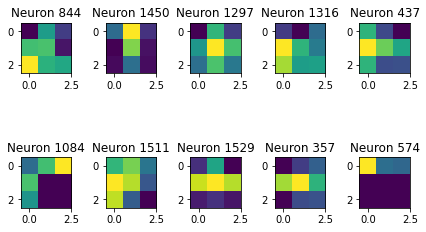

In [29]:
total_layers = len(base_model.layers) #Get the lenght of layers in base model
output_layers = [layer.output for layer in base_model.layers[total_layers-2:total_layers]] #Getting the last 2 layers from base model
activation_model = models.Model(inputs = base_model.input, outputs = output_layers)
activation_predictions = activation_model.predict(x_pred) #Predict on the new images
activations = activation_predictions[1]# Use last activation layer for visualizing the object localization

for image in image_name_list[:4]: #Two images (test4.jpeg and test5.jpeg) with class 0 and 2 images (test16.jpeg and test19.jpeg) with class label 1
  print("Object Localization for image {}:".format(image))
  rows = 2
  cols = 5
  axes=[]
  fig=plt.figure()
  idx = 0
  for a in range(rows*cols):
    axes.append( fig.add_subplot(rows, cols, a+1) )
    # plt.subplots_adjust(wspace = 0, hspace=-0.1)
    subplot_title=("Neuron "+str(highly_correlated_neurons_list[idx]))
    axes[-1].set_title(subplot_title)  
    plt.imshow(activations[0,:,:,highly_correlated_neurons_list[idx]],cmap='viridis')
    idx+=1
  fig.tight_layout()    
  plt.show()
  print("")
  print("")

**References**

1. Chollet, F., 2017. Deep Learning with Python.